In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt

/tmp/ipykernel_3231919/3799100850.py:20: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [15]:
import importlib
importlib.reload(dp)
importlib.reload(dplt)

<module 'functions_plotting' from '/home/s377963/car_t_sc/02_code/functions/functions_plotting.py'>

### Import the preprocessed data

In [6]:
adata = sc.read('01_data/processed/integrated/merged_qc_filtered_abs.h5ad')
nas = pd.isna(adata.obs.Tcell_subtype)
adata_nona = adata[~nas,:].copy()

In [7]:
days = ['0', '7', '14']
conditions = ['C', 'DM', 'P']
dplt.add_DaysConds_to_adata(adata_nona, days, conditions)

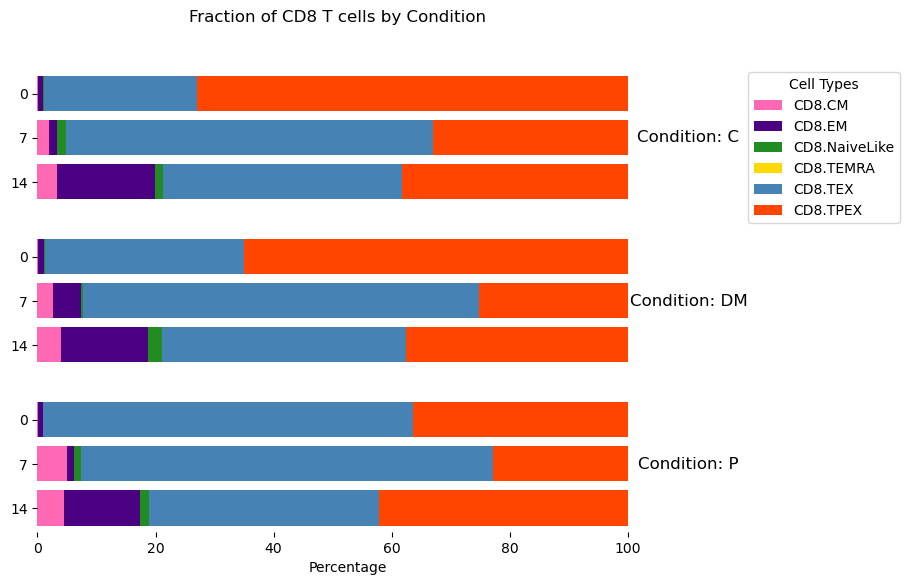

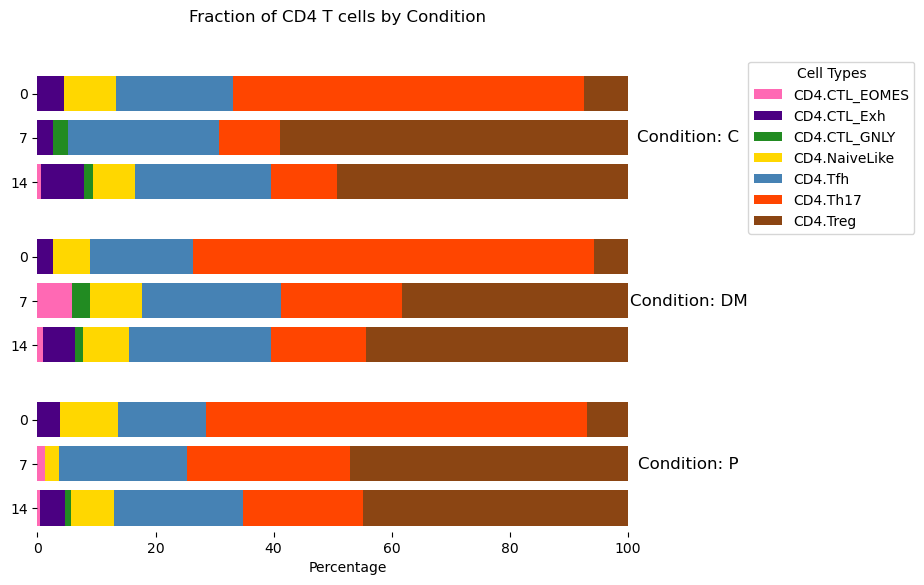

In [16]:
dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')